## CMPE 297 - Assignment 3 - Part 4
## Sentence Correction

#1.0 Load libraries

In [10]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorboard import notebook

# 2.0 Read in the Cola dataset

In [11]:
!mkdir -p data/raw
!curl https://dl.fbaipublicfiles.com/glue/data/CoLA.zip -L -o data/raw/raw.zip
!unzip data/raw/raw.zip -d data/raw

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  368k  100  368k    0     0   237k      0  0:00:01  0:00:01 --:--:--  237k
Archive:  data/raw/raw.zip
replace data/raw/CoLA/dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/raw/CoLA/original/raw/in_domain_dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/raw/CoLA/original/raw/in_domain_train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/raw/CoLA/original/raw/out_of_domain_dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/raw/CoLA/original/tokenized/in_domain_dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/raw/CoLA/original/tokenized/in_domain_train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/raw/CoLA/original/tokenized/out_of_domain_dev.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/raw/CoLA/test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

#3.0 Prepare the train, test set

In [12]:
train_df = pd.read_csv("./data/raw/CoLA/train.tsv", names=["id", "label", "etc", "text"], sep='\t')
train_X = tf.constant(train_df.text)
train_y = tf.constant(train_df.label)
train_df.head()

,id,label,etc,text
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [19]:
test_df = pd.read_csv("./data/raw/CoLA/test.tsv", names=["id", "label", "etc", "text"], sep='\t')
test_X = tf.constant(test_df.text)
test_y = tf.constant(test_df.label)
test_df.head()

,id,label,etc,text
0,index,sentence,NaN,NaN
1,0,Bill whistled past the house.,NaN,NaN
2,1,The car honked its way down the road.,NaN,NaN
3,2,Bill pushed Harry off the sofa.,NaN,NaN
4,3,the kittens yawned awake and played.,NaN,NaN


#4.0 Load pre-trained nnlm embeddings

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_X[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.3174644 ,  0.21877529, -0.11859256,  0.21564397, -0.03717417,
        -0.08188752,  0.128495  ,  0.15144543, -0.15268897,  0.16399409,
        -0.01233621,  0.18260562,  0.23977268,  0.20133935,  0.17345858,
        -0.05107261, -0.11782473,  0.05793202, -0.00600127, -0.05251225,
        -0.10689204, -0.25679952,  0.14195757, -0.29401127,  0.07582158,
         0.23679148, -0.50280464,  0.15188406, -0.01288533, -0.09701494,
         0.05093776,  0.04176186,  0.2709011 , -0.23006576,  0.01572436,
         0.21390316,  0.1978745 , -0.10836355, -0.06744416, -0.00777094,
         0.13987754, -0.0267532 , -0.16538641, -0.00503848, -0.07102694,
         0.15057778, -0.18263315, -0.0398521 ,  0.10929692, -0.0725039 ],
       [-0.09138185,  0.16842113,  0.00289669,  0.09841394, -0.06016617,
        -0.1270382 ,  0.07416186, -0.12718596, -0.13069929,  0.2525887 ,
         0.06409024,  0.13146687, -0.09484915,  0.05056581, -0.00921336,
 

#5.0 Build the model with w&b settings

In [16]:
# Installing wandb library for experiment tracking and hyper parameter optimization
!pip install -q wandb

# login to wandb
!wandb login

wandb: Currently logged in as: abais (use `wandb login --relogin` to force relogin)


In [22]:
# libs for w&b hyper param tuning and callback
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.optimizers import SGD

# define hyperparameters for w&b
defaults=dict(
    batch_size = 32,
    dropout = 0.2,
    hidden_layer_size = 128,
    layer_1_size = 16,
    layer_2_size = 32,
    learn_rate = 0.01,
    decay = 1e-6,
    momentum = 0.9,
    epochs = 5,
    )

# init w&b
wandb.init(project="sentence_correction", config=defaults)
config = wandb.config

# build the model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# setup optimizer
sgd = SGD(lr=config.learn_rate, decay=config.decay, momentum=config.momentum,
                            nesterov=True)
model.compile(optimizer=sgd,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# 6.0 Fine Tune the model using w&b

In [23]:
history = model.fit(x=train_X, 
                    y=train_y,  
                    validation_split=0.2,
                    epochs=config.epochs,
                    callbacks=[WandbCallback(data_type="text")],
                    verbose=1)

Epoch 1/5
214/214 [==============================] - 3s 5ms/step - loss: 0.6233 - accuracy: 0.6365 - val_loss: 0.5909 - val_accuracy: 0.7241
Epoch 2/5
214/214 [==============================] - 2s 8ms/step - loss: 0.6120 - accuracy: 0.6949 - val_loss: 0.5928 - val_accuracy: 0.7236
Epoch 3/5
214/214 [==============================] - 1s 5ms/step - loss: 0.6095 - accuracy: 0.6988 - val_loss: 0.5926 - val_accuracy: 0.7230
Epoch 4/5
214/214 [==============================] - 1s 5ms/step - loss: 0.6076 - accuracy: 0.6955 - val_loss: 0.5899 - val_accuracy: 0.7253
Epoch 5/5
214/214 [==============================] - 1s 5ms/step - loss: 0.6060 - accuracy: 0.6962 - val_loss: 0.5910 - val_accuracy: 0.7247


#6.0 Show weights and bias train, test loss, accuracy curves

1. [Weights and Bias Train/Test Report](https://wandb.ai/abais/sentence_correction/reports/Sentence-Correction--VmlldzoxMTM1NjUx?accessToken=8e73nzui0h2h0xutew3vl36qkb9yn3wlo8engflowa3n87qxunmlv51if264pip3)

2. Image from the report is captured below

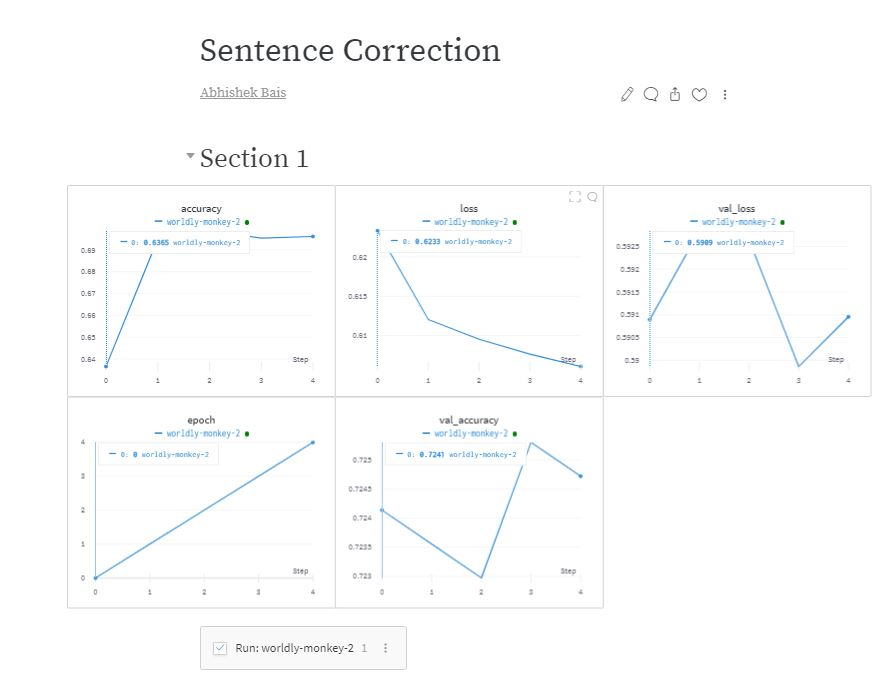

#7.0 Save Fine Tuned model to W&B

In [25]:
import os
model.save(os.path.join(wandb.run.dir, "sentence_correction.h5"))
wandb.save('sentence_correction.h5')

['/content/wandb/run-20211020_001958-8wnt18ik/files/sentence_correction.h5']

#8.0 Restore Fine Tuned Model

In [27]:
best_model = wandb.restore('sentence_correction.h5', run_path="abais/sentence_correction/runs/2tt75tld")
restored_model = model
restored_model.load_weights(best_model.name)

#9.0 Inferencing using Gradio

In [28]:
!pip install gradio

     |████████████████████████████████| 3.6 MB 13.1 MB/s 
     |████████████████████████████████| 1.9 MB 47.4 MB/s 
     |████████████████████████████████| 206 kB 77.9 MB/s 
     |████████████████████████████████| 63 kB 3.5 MB/s 
     |████████████████████████████████| 961 kB 55.5 MB/s 
     |████████████████████████████████| 3.5 MB 49.1 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=b5b18075c6f3f16dde7d756d3cabcdad4019083b02ae01ce06336ab0a25cffa1
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=77b0d5fd78e0200de4c0f61998eccf121e0c9476388796e8fb16790f12c5a0e6
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [29]:
import gradio as gr

def get_prediction(text):
  def get_class(score):
    if score > 0:
      return "sentence is grammar wise correct"
    else:
      return "sentence has grammar errors"
  
  score = inference_model.predict([text]).item(0)
  return score, get_class(score)

In [30]:
inference_model = restored_model
iface = gr.Interface(fn=get_prediction, inputs="text", outputs=["number", "text"])
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://14926.gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://14926.gradio.app')

#10.0 Gradio output capture  
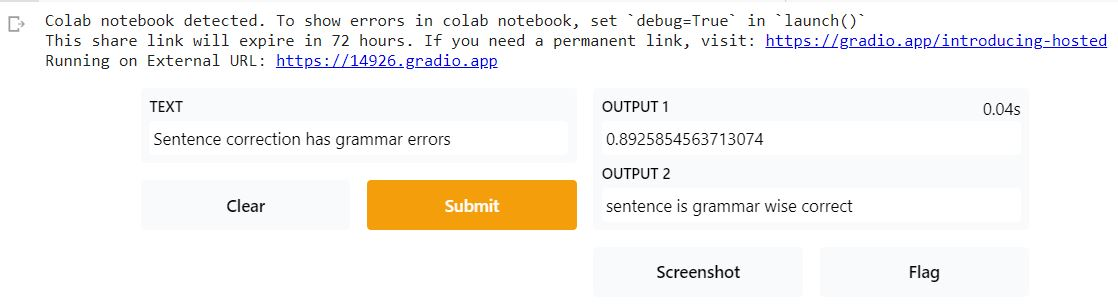 